In [1]:
import torch
from torch.autograd import Variable
from torchvision import models
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dataset
from finetune import PrunningFineTuner
from ModifiedModels import ModifiedVGG16
import time
import random
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_dir = "Cat_Dog_data/"
train_path = dataset_dir+"train"
test_path = dataset_dir+"test"

In [4]:
#load the training and tet dataset
train_data_loader = dataset.loader(train_path, size = 224)
test_data_loader = dataset.test_loader(test_path, size = 224)

In [5]:
#Create a modified VGG16
vgg16 = ModifiedVGG16().to(device)

In [6]:
vgg16.eval()

ModifiedVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, 

In [7]:
epoches = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.0001, momentum=0.9)

In [8]:
def train(model, optimizer, epoches, train_data_loader, test_data_loader, device ):
    
    for i in range(epoches):
        print("Epoch: ", i, end="  ")
        for i, (batch, label) in enumerate(train_data_loader):
            
            batch = batch.to(device)
            label = label.to(device)
            model.zero_grad()
            batch = Variable(batch)
            criterion(model(batch), Variable(label)).backward()
            optimizer.step()
        
        test(model, test_data_loader, device)

In [9]:
def test(model, test_data_loader, device):
    model.eval()
    correct = 0
    total = 0
    for i, (batch, label) in enumerate(test_data_loader):
        batch = batch.to(device)
        output = model(Variable(batch))
        pred = output.data.max(1)[1]
        correct += pred.cpu().eq(label).sum()
        total += label.size(0)

    print("Accuracy :", float(correct) / total)

In [10]:
start = time.time()
train(vgg16, optimizer, epoches, train_data_loader, test_data_loader, device)
end = time.time()
print(end - start)

Epoch:  0  Accuracy : 0.982
Epoch:  1  Accuracy : 0.9848
Epoch:  2  Accuracy : 0.9856
Epoch:  3  Accuracy : 0.9852
Epoch:  4  Accuracy : 0.9856
692.0055088996887


In [12]:
torch.save(vgg16, "models/vgg16")

In [13]:
vgg16 = torch.load("models/vgg16")

In [14]:
fine_tuner_vgg16 = PrunningFineTuner(train_path, test_path, vgg16, device, size = 224)
fine_tuner_vgg16.total_num_filters()

4224

In [15]:
def prune(model):
    hist = {"parameters":[], "accuracy":[], "filters":[], "time":[]}
    number_of_filters = model.total_num_filters()
    filter_per_iteration = int(number_of_filters*0.2)
    
    hist["parameters"].append(model.get_number_of_parameters())
    hist["filters"].append(filter_per_iteration)
    start = time.time()
    acc = model.test()
    end = time.time()
    hist["accuracy"].append(acc)
    hist["time"].append(end-start)
    for i in range(4):
        print("-------------------------------")
        acc = model.prune(filter_per_iteration)
        if(i%2 == 1):
            torch.save(model, "models/alexnet_prunned"+str(i))
        hist["parameters"].append(model.get_number_of_parameters())
        hist["filters"].append(hist["filters"][-1]+filter_per_iteration)
        start = time.time()
        acc = model.test()
        end = time.time()
        hist["accuracy"].append(acc)
        hist["time"].append(end-start)
    return hist

In [16]:
#prune the filters in the model
hist = prune(fine_tuner_vgg16)

-------------------------------
Accuracy before pruning: 0.986
Number of filters to prune 844
Ranking filters.. 
Layers that will be prunned {28: 204, 17: 102, 24: 111, 21: 92, 7: 11, 12: 26, 10: 42, 19: 80, 26: 128, 0: 9, 14: 25, 5: 10, 2: 4}
Prunning filters.. 
Filters prunned 19.981060606060606%
Accuracy after pruning: 0.8916
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9792
Finished fine tuning.
-------------------------------
Accuracy before pruning: 0.9792
Number of filters to prune 844
Ranking filters.. 
Layers that will be prunned {5: 14, 17: 101, 28: 123, 26: 123, 19: 117, 24: 132, 21: 109, 7: 14, 12: 40, 14: 30, 10: 23, 0: 9, 2: 9}
Prunning filters.. 
Filters prunned 24.97041420118343%
Accuracy after pruning: 0.894
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9812
Finished fine tuning.


/usr/lib/python3.9/site-packages/torch/utils/hooks.py:57: UserWarning: backward hook <bound method FilterPrunner.compute_rank of <finetune.FilterPrunner object at 0x7f21740608b0>> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "


-------------------------------
Accuracy before pruning: 0.9812
Number of filters to prune 844
Ranking filters.. 
Layers that will be prunned {26: 117, 10: 54, 24: 99, 14: 43, 17: 118, 21: 118, 12: 48, 28: 95, 19: 105, 7: 18, 0: 8, 5: 16, 2: 5}
Prunning filters.. 
Filters prunned 33.2807570977918%
Accuracy after pruning: 0.51
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9556
Finished fine tuning.
-------------------------------
Accuracy before pruning: 0.9556
Number of filters to prune 844
Ranking filters.. 
Layers that will be prunned {24: 92, 14: 76, 21: 117, 17: 107, 19: 121, 28: 54, 12: 65, 10: 56, 26: 76, 7: 25, 2: 12, 5: 29, 0: 14}
Prunning filters.. 
Filters prunned 49.881796690307326%
Accuracy after pruning: 0.5
Retrain to recover from prunning iteration.
Epoch:  0
Accuracy : 0.93
Finished fine tuning.


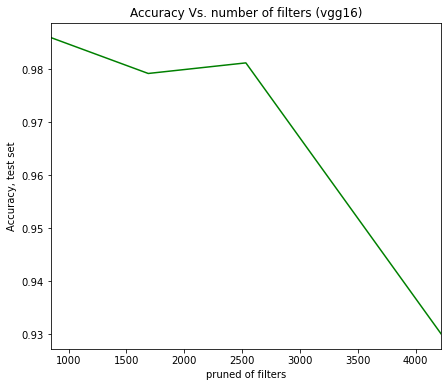

In [17]:
plt.figure(figsize=(7, 6))
plt.plot(hist["filters"], hist["accuracy"], color='green')
plt.xlabel('pruned of filters')
plt.ylabel('Accuracy, test set')
plt.xlim(hist["filters"][0], hist["filters"][-1])
plt.title("Accuracy Vs. number of filters (vgg16)")
#plt.legend()
plt.savefig('images/prunningfiltersVgg16.png')

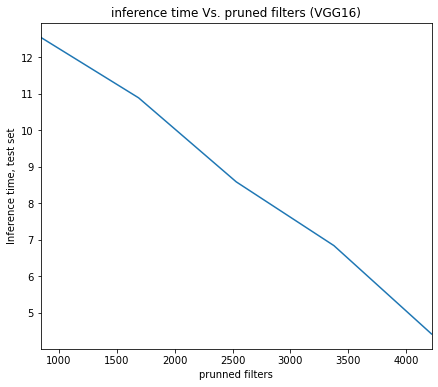

In [18]:
plt.figure(figsize=(7, 6))
plt.plot(hist["filters"], hist["time"])
plt.xlabel('prunned filters')
plt.ylabel('Inference time, test set')
plt.xlim(hist["filters"][0], hist["filters"][-1])
plt.title("inference time Vs. pruned filters (VGG16)")
plt.savefig('images/inferenceTimeVGG16.png')